# $$\text{WEATHER - SEOUL}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [1608]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [1609]:
data = pd.read_csv('mumbai.csv')
data['datetime'] = pd.to_datetime(data['datetime'], format="%d-%m-%Y")

In [1610]:
# data = pd.read_csv('seoul.csv')
# data['datetime'] = pd.to_datetime(data['datetime'])
data.isnull().sum()

datetime            0
temp                0
dew                 0
humidity            0
sealevelpressure    0
winddir             0
solarradiation      0
windspeed           0
precipprob          0
preciptype          0
dtype: int64

In [1611]:
data.head()

,datetime,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
0,2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0
1,2016-01-02,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0
2,2016-01-03,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0
3,2016-01-04,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0
4,2016-01-05,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2022-01-01 do 2024-01-01 (tzn. 'równe oddalenie w czasie')?

In [1612]:
data_copy = data.copy()

In [1613]:
data_copy['datetime'] = pd.to_datetime(data_copy['datetime'])
data_copy.set_index('datetime', inplace=True)
data_copy.sort_index(inplace=True)

In [1614]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [1615]:
data_clean = data[['datetime', 'windspeed']]
data_clean.head()


,datetime,windspeed
0,2016-01-01,16.6
1,2016-01-02,16.6
2,2016-01-03,18.4
3,2016-01-04,16.6
4,2016-01-05,16.6


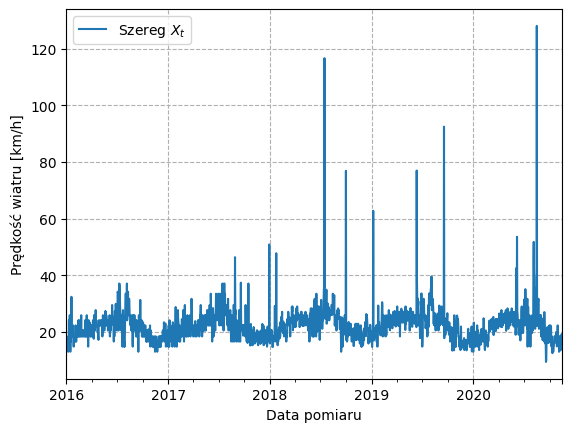

In [1616]:
data_clean.plot(x='datetime', y='windspeed', label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Prędkość wiatru [km/h]')
plt.xlabel('Data pomiaru')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [1617]:
# minimalna i maksymalna prędkość wiatru
min_wind = np.min(data_clean['windspeed'])
max_wind = np.max(data_clean['windspeed'])

print('Minimalna prędkość wiatru w danych:', min_wind)
print('Maksymalna prędkość wiatru w danych:', max_wind)

Minimalna prędkość wiatru w danych: 9.4
Maksymalna prędkość wiatru w danych: 128.1


- niekompletne dane: NIE

In [1618]:
data_clean.isnull().sum()

datetime     0
windspeed    0
dtype: int64

    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [1619]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [1620]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [1621]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

In [1622]:
Xt = data['windspeed'].values
Xt= Xt[Xt <= 60]
h = 40

In [1623]:
h_range = np.arange(h+1)
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

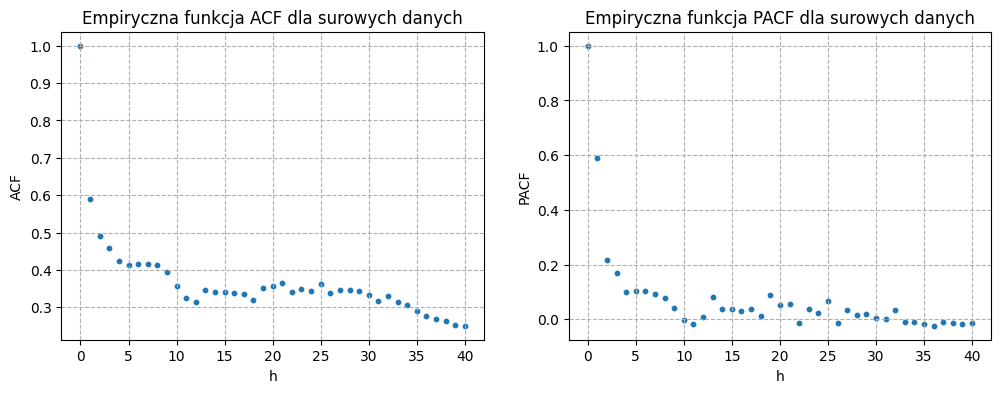

In [1624]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

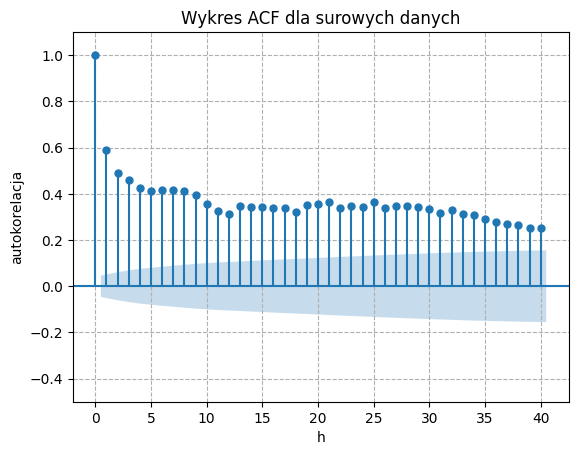

In [1625]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

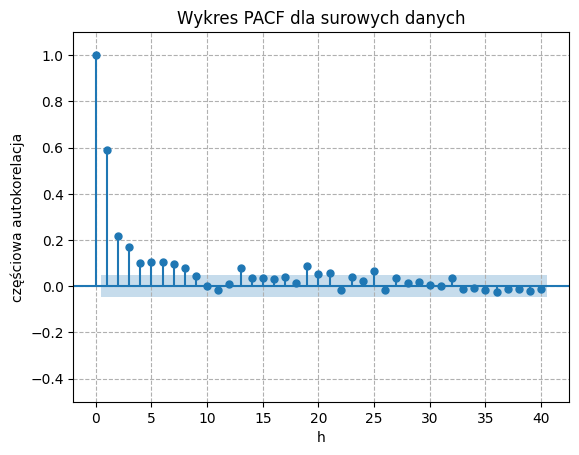

In [1626]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [1627]:
n = len(Xt)
t = np.linspace(0, n, n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [1628]:
delta_Xtm = Xt - mt

- sezonowość s(t)

In [1629]:
def s_func_para(t, a, b, c, d):
    return a*np.sin(b*t + c) + d

In [1630]:
a_initial = (Xt.max() - Xt.min()) / 2
b_initial = 2 * np.pi / 365
c_initial = 0
d_initial = np.mean(Xt)

params, covariance = curve_fit(s_func_para, t, delta_Xtm, p0=[a_initial, b_initial, c_initial, d_initial])

a_fit, b_fit, c_fit, d_fit = params
st = s_func_para(t, a_fit, b_fit, c_fit, d_fit)

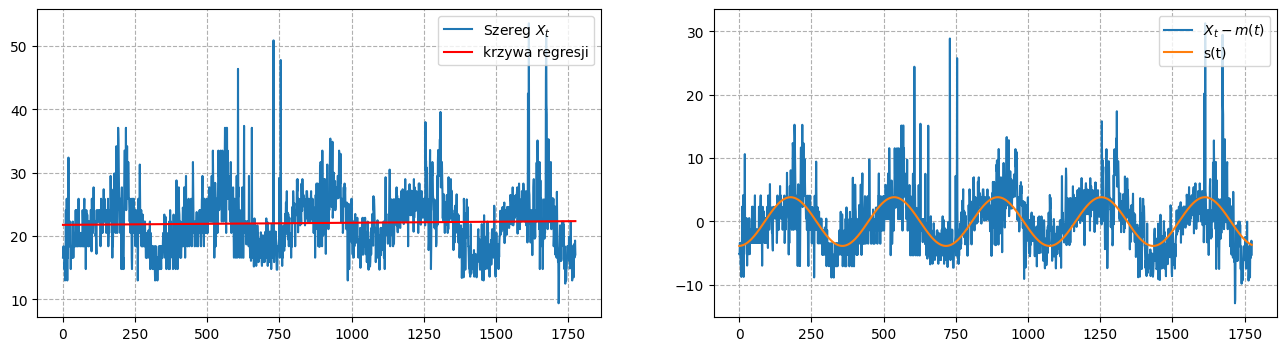

In [1631]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(t, Xt, label = 'Szereg $X_t$')
plt.plot(t, mt, color = 'red', label = 'krzywa regresji')
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(t, delta_Xtm, label = '$X_t - m(t) $')
plt.plot(t, st, label = 's(t)')
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.show()

- Szereg czasowy liniowy $Y_t$

In [1632]:
Yt = Xt - mt - st

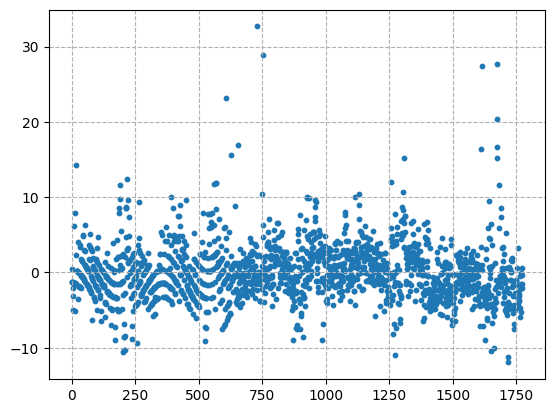

In [1633]:
plt.scatter(t, Yt, s=10, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.show()

    2.4. Wykres ACF oraz PACF dla uzyskanego szeregu

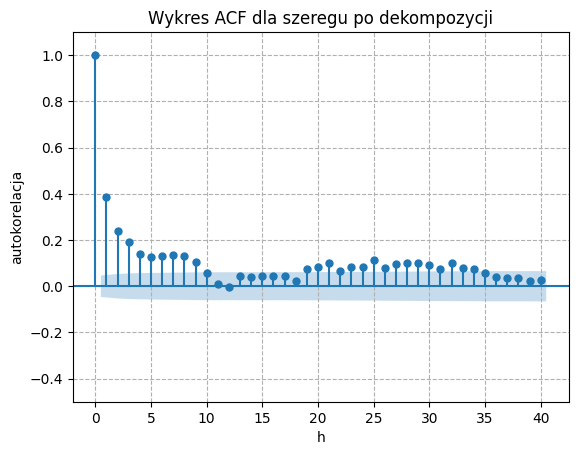

In [1634]:
plot_acf(Yt, lags=h)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

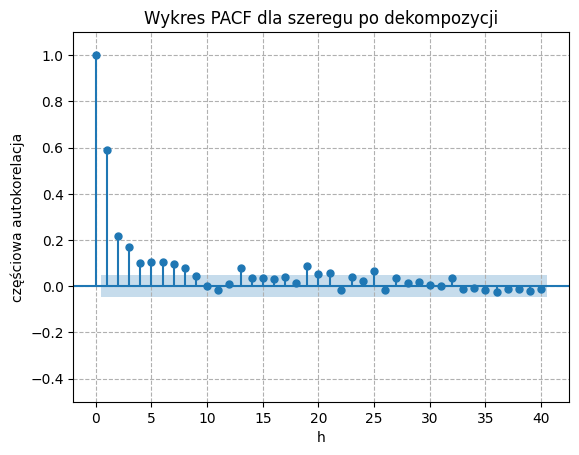

In [1635]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

    3.2. Estymacja parametrów modelu wybraną metodą.

##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

## 6. Podsumowanie